<a href="https://colab.research.google.com/github/tjger256/Solar-Detection-using-ML/blob/main/Solar_Panel_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Necessary Librabries

In [ ]:
# Data handling and linear algebra
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt # for chart
import matplotlib as mpl
from pylab import rcParams # used for setting global configuation for plots
import seaborn as sns

# Data Analysis
from sklearn.model_selection import StratifiedKFold # cross validation techniques,
#making sure the dataset contain the same percentage of the samople
from sklearn.metrics import roc_auc_score # ROC AUC is a performance metric for binary
#classification problems that measures the area under the ROC curve
from sklearn.metrics import roc_curve
# is a graphical representation of the true positive rate (sensitivity)
# against the false positive rate (1-specificity) at various threshold settings.
from sklearn.metrics import confusion_matrix

# Manipulating Data and Model building
from keras.layers import Conv2D #  represents a 2D convolutional layer
from keras.layers import Dense # This class represents a fully connected layer, also known as a dense layer.
from keras.layers import GlobalMaxPooling2D # downside the whote pic, take the biggest values
from keras.layers import MaxPooling2D # use a kennel to kgo therough all the result and downside
from keras.layers import BatchNormalization # used for maning the sside of the bacth,
#make sure the batch dont be too big or too small , increasew the performance.
from keras.layers import Add # Add helps you do that by adding the values from different parts together.
from keras.models import Sequential # Sequential helps you stack layers on top of each other


### Importing the data

This getting the data from the google drive. Here is how to import the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DIR_TRAIN_IMAGES = "/content/drive/MyDrive/data/training/"
DIR_TRAIN_LABELS = "/content/drive/MyDrive/data/labels_training.csv"
# for trainning data imaging, thwere always need the 2 files, one file with images and the other fileks with labels

Read the label- the identification of the image

0 value represent no solar

1 value represent solar

In [ ]:
pd.read_csv(DIR_TRAIN_LABELS).head()

,id,label
0,0,0
1,1,0
2,2,1
3,3,1
4,4,1


In [ ]:
# Loading the data; create a data frame and use function load data to create a data frame, convert the image into array.
def load_data(dir_data, dir_labels):
  labels_pd = pd.read_csv(dir_labels) # read the label file
  ids = labels_pd.id.values # load the id value
  data = []
  for identifier in ids:
    fname = dir_data + identifier.astype(str) + '.tif'
    # this code define the name so the mpl funtion can locate the image and read it
    # dir_data direct the data to the file, identifier identify the name as string, 'tif' is the file type
    image = mpl.image.imread(fname)
    #mpl.image.imread turn the image into an array of data point, each pixel will be a data in the array
    data.append(image)
    #This code puut the converted data into the dataframe
  data = np.array(data) # This code turn the list of data into an array
  labels = labels_pd.label.values
  # label column is extract to the labels variable
  return data, labels
# This code will create a afuntion to read the image and label, then return the image as an array of pixel and label



In [ ]:
X, y = load_data(DIR_TRAIN_IMAGES, DIR_TRAIN_LABELS)
#This load the data into X and y

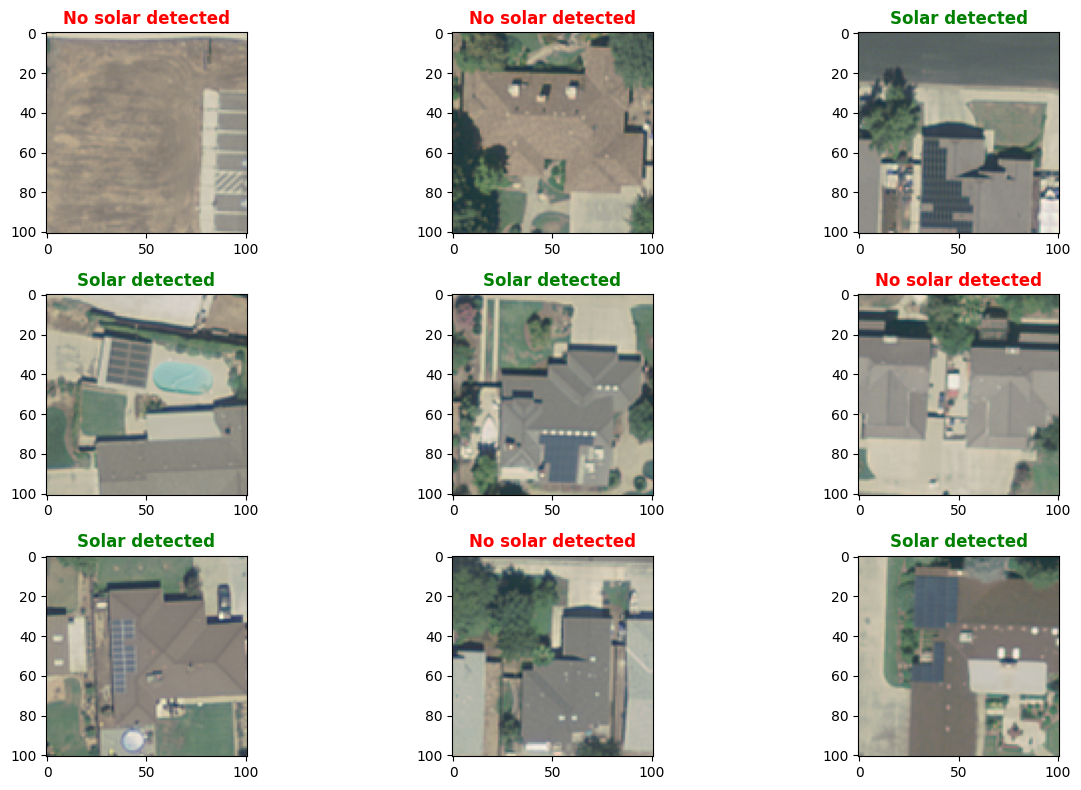

In [ ]:
# display a sample of first picture that contain solar panel and not contain solar panels
plt.figure(figsize = (13,8))
for i in range(9):
  plt.subplot(3,3,i+1)
  #create a subplot 3x3 and the order of the images, The i +1 to make the order left to right, up to down
  plt.imshow(X[i])
  # everytime you want to display the image need to use this function to go from array list to image
  if y[i] == 0:
    title = "No solar detected"
    plt.title(title, color = 'r', weight = 'bold')
  # if y value of eacha pic equal to 0 --> no solar
  else:
    title = "Solar detected"
    plt.title(title, color = 'g', weight = 'bold')
plt.tight_layout() #used to automatically adjust the positions of axes and subplots to prevent them from overlapping with each other.
plt.show()

In [ ]:
#print shape of the data
print(X.shape)

(1500, 101, 101, 3)


There is a total of 1500 image with the size of

101x101x3

In [ ]:
# check number of no solar panel images vs solar panel images
print('Non-solar panel vs solar panel images:', np.bincount(y))
#the np.bincount() used for count the distinct values, the order will followed y

Non-solar panel vs solar panel images: [995 505]


There is 995 image with non- solar and 505 image with solar

In [ ]:
# Scale the pixel value between 0 and 1
X = X /255.0

For every pixel, there is a total of 256 values(including 0) represent for each color, dividing X to 255 turn its pixel value from 0-1.

### Building the model

In [ ]:
def build_model():

  # define image dimensioins
  # The purpose of defining the image dimension for a clear structure, later on, you can use other iamge data and still be a ble to do it
  IMAGE_HEIGHT = 101
  IMAGE_WIDTH = 101
  IMAGE_CHANELS = 3 # the image chanel show the type of color, with black and white- Garyscale will be 1, color will be 3( blue, green, red)

  #create a Sequential neural network so we can add layers into it later
  model = Sequential()

  # Create a layer 1
# This is whre the add function come in
  model.add(Conv2D(filters=32, # as you go deeper into the model, the number of fiters tend tp increase
                   kernel_size = 3,
                   activation='relu', #relu to turn negative svalues to 0, keep positive values
                   # In this case, all the values is positive but relu still here to help on the performance.
                   input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANELS)))

  # filters=32 : Mean the number of kernel used
  # kernel_size = 3: mean we use a windown filter of 3x3
  # Relu help the funtion non-linear by deleting the negative values on the feature table and keep the positive values
  # input_shape: in CNN model, the first layer need to let the model know the shape of the input data
  model.add(BatchNormalization())
   # after each layer, we should add BatchNormalization so it can improve the performance of the model
  #A normalization method to standardlize the data after each layer help increase the performance and speed up the training process

  # Create layer 2
  model.add(Conv2D(filters=64,
                   kernel_size = 3,
                   activation='relu'))
  model.add(BatchNormalization())

  # Create layer 3
  model.add(Conv2D(filters = 128,
                   kernel_size = 3,
                   activation ='relu'))
  model.add(BatchNormalization())
  # We apply maxpooling in this layer
  model.add(MaxPooling2D(pool_size = 2))
  # MaxPooling = 2 means the feature table is filtered by an windown 2x2, the largest value in the windown will be kept
  # To decide where to put the MaxPooling, when the number of filter incease a lot, we want to reduce the complexity
  # MaxPoling will reduce the size of the feature table.

  # Create layer 4
  model.add(Conv2D(filters = 64,
                   kernel_size = 3,
                   activation ='relu'))
  model.add(BatchNormalization())

  #Create layer 5
  model.add(Conv2D(filters = 128,
                   kernel_size = 3,
                   activation ='relu'))
  model.add(BatchNormalization())
  # We apply another MaxPooling for this layer
  model.add(MaxPooling2D(pool_size=2))
  # DO you notice that everytime the number of filter =128 there is a maxPooling layer?
  # Create layer 6
  model.add(Conv2D(filters = 64,
                   kernel_size = 3,
                   activation = 'relu'))
  model.add(BatchNormalization())

  #Create layer 7
  model.add(Conv2D(filters = 128,
                   kernel_size = 3,
                   activation = 'relu'))
  model.add(BatchNormalization())
  # In the last layer before Dense layer, to avoid overfitting and reduce the computational power
  # We will use GlobalMaxPooling to reduce the size of each feature map into 1 digit.
  # This will will make the transition to Dense layer more effective and avoid oferfiting.
  model.add(GlobalMaxPooling2D())

  #Create output layer
  model.add(Dense(1, activation = 'sigmoid'))
  # the number 1 indicates the Dense layer contains a single neuron.
  # In classification - such as solar or not solar, 1 neuron normally be used
  # Signmoid funtion used for binary classification tasks.
  # In the case of multiple classification such as: identify dog, cat, bird, ect, the number of neuron = number of classes with softmax activation funtion

  #this code setting up the rule on how the model should be run
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  # optimizer = 'adam': a popular guide to make sure the model run fast and well
  #loss = 'binary_crossentropy': the model will evaluate itself how far it  is from the actual result, the smaller the loss the higher accuracy
  #metrics = ['accuracy']: The model wil tell you the accuracy after each batch
  return model



### Checking model performance

In [ ]:
# Building cross validation for CNN model
def cv_performance_assessment(X,y,num_folds, clf, random_seed = 1):
#clf: The classification method that be used
# ramdom_seed means everytime we run the function, the funtion will be reset and run as brand new and we still have the same result
  prediction_scores = np.empty(y.shape[0], dtype ='object')
  # this will create an empty array using y

# Establish Kfold
  kf = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=random_seed)
  # n_splits : data will be splitted to this number of fold
  # In this casem we didn't use cross_validate because StratifiedKFold offers a more manual solution - more flexibility
  # shuffle = true means the data will be shuffred before putting into folds
  # random_state = random_seed means everytime your data will be the same, both the data and the folds order

  for train_index, val_index in kf.split(X,y): # need to folow the order train_index
    # extract the training and validation data for this fold
    X_train, X_val = X[train_index], X[val_index]
    y_train = y[train_index]
    # after use kf.split(X,y), we will have 4 set: X[train_index], X[val_index], y[train_index],y[val_index]
    # those will extract the data into those values  X_train, X_val, and y_train

    #give wieght to ballance the classes
    class_weight = {0: 505/1500, 1: 995/1500}
    # becase in the data, the number of non solar is 995 and solar image is 505
    # to balance this, we give more weight to the images with solar panel

    #train the classifier
    training = clf.fit(x=X_train,
                       y = y_train,
                       class_weight=class_weight,
                       batch_size = 32,
                       epochs = 10,
                       shuffle = True,
                       verbose = 1)
    #batch_size = 32: this means how many data point will be processed at a time to reduce the computer power
    # The epochs = 10 means we go throught all the data 10 times since each time we go through the model will learn a bit better
    # The verbose = 1 like creating a report for each epochs how the model has learned better
    # shuffle = True: This specific argument tells the model to shuffle the training data before each epoch.

    # using the X-val to predict potential y_val for later comparision
    y_val_pred_probs = clf.predict(X_val).reshape((-1, ))

    #save the predictions into prediction_scores[val_index]
    prediction_scores[val_index] = y_val_pred_probs

  return prediction_scores



In [ ]:
# number of subnet data, where the last subnet is used for tesing and k-1 subnets are used for training purpose
num_folds = 3

# seed value is the previous value generated by the random function
random_seed = 1

#assign cnn variable as the funtion
cnn = build_model()

# lets look at summary of the model
cnn.summary()

# generate the probabilities (y_pred_prob)
cnn_y_hat_prob = cv_performance_assessment(X,y, num_folds, cnn, random_seed = random_seed)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 99, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 99, 99, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 97, 97, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 95, 95, 128)       73856     
                                                                 
 batch_normalization_2 (Bat  (None, 95, 95, 128)       5

### Display the four values: TP, TN, FP, FN

In [ ]:
# In this step', we create a dataframe with y data and compare the training data with the actual data
df = pd.read_csv(DIR_TRAIN_LABELS)
# We used both if and for in 1 line of code to turn all the probability values into 0 or 1 for a better comparision
df["predicted_class"] = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]
#Make comparision between the y values and the value from the new "predicted_class" column
# We get the FN,FP,TP,TN
fn = np.array(df[(df['label'] == 1)&(df['predicted_class'] == 0)]['id'])
fp = np.array(df[(df['label'] == 0)&(df['predicted_class'] == 1)]['id'])
tn = np.array(df[(df['label'] == 0)&(df['predicted_class'] == 0)]['id'])
tp = np.array(df[(df['label'] == 1)&(df['predicted_class'] == 1)]['id'])
# In the above code, we make a comparision between two columns and extract their 'id' values



In [ ]:
fn

array([   2,    3,    6,    8,   10,   24,   30,   32,   37,   45,   48,
         54,   59,   60,   70,   71,   73,  103,  106,  108,  117,  125,
        130,  134,  137,  140,  148,  150,  156,  157,  158,  161,  163,
        172,  182,  183,  185,  188,  194,  195,  197,  217,  220,  225,
        231,  234,  247,  249,  254,  255,  259,  261,  262,  266,  280,
        288,  291,  294,  302,  305,  307,  310,  312,  321,  325,  329,
        339,  344,  348,  351,  354,  360,  364,  378,  383,  384,  388,
        392,  405,  422,  428,  429,  430,  437,  438,  445,  458,  459,
        464,  483,  486,  488,  491,  496,  497,  500,  502,  503,  505,
        522,  526,  527,  534,  566,  578,  590,  594,  597,  598,  618,
        619,  631,  633,  635,  636,  643,  649,  668,  672,  674,  677,
        698,  705,  712,  723,  728,  732,  737,  740,  742,  756,  757,
        764,  767,  774,  776,  783,  791,  793,  806,  815,  820,  826,
        829,  834,  835,  836,  843,  859,  884,  8

In [ ]:
# Visual the four values, TP,TN,FP,FN
# In this step we create a fruntion to display the images
def show_images(image_ids, num_images, title, color):
  rcParams['figure.figsize']= 20,4
  plt.figure()
  n = 1
  for i in image_ids[0:num_images]:
    plt.subplot(1, num_images, n)# Creates a subplot for each image. The subplot grid is 1 row by num_images columns, and n specifies the current subplot's position.
    plt.imshow(X[i,:,:,:])
    #i represent the image id, every : allow access to height, width, and color chanel
    plt.title('Image id: ' + str(i))
    plt.axis('off') # Turns off the axis lines and labels.
    n+=1
  plt.suptitle('\n' + title, fontsize = 15, color = color, weight = 'bold')
  plt.show()


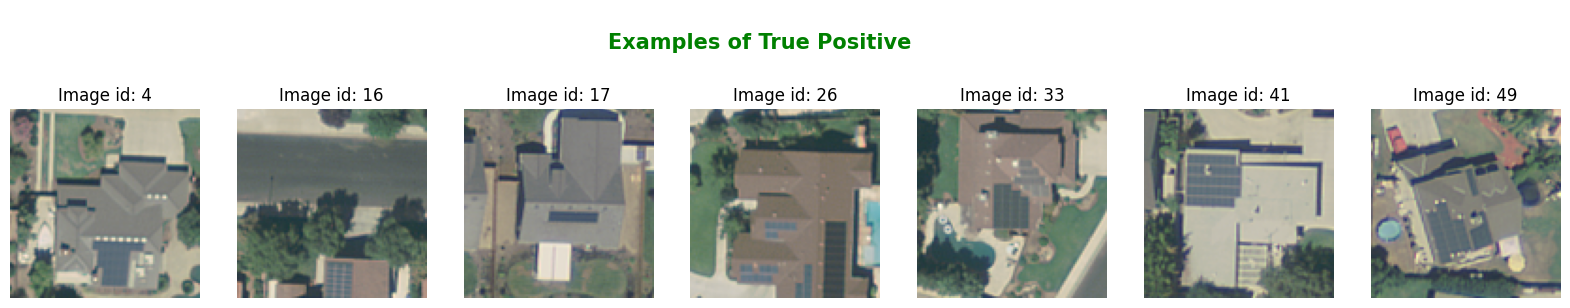

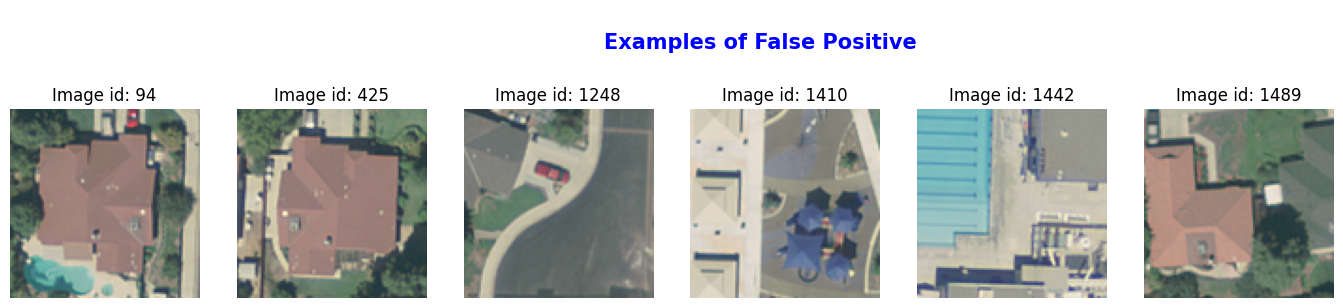

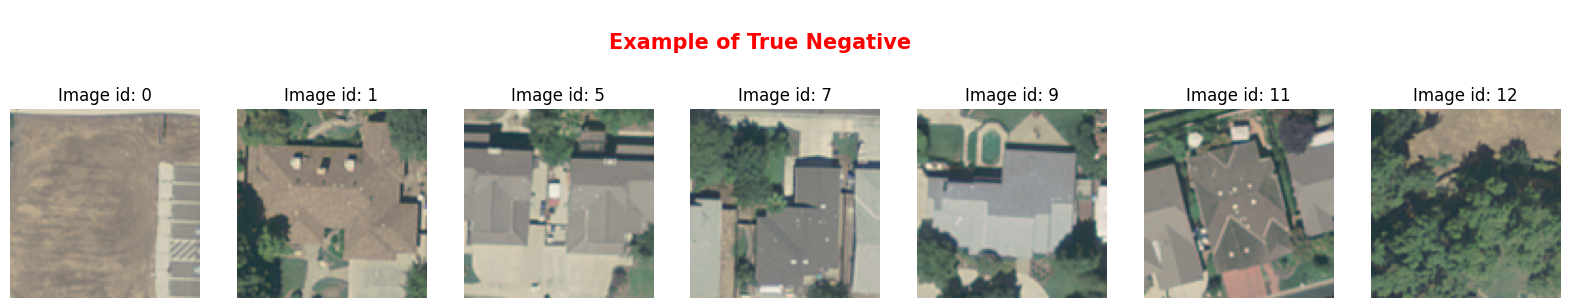

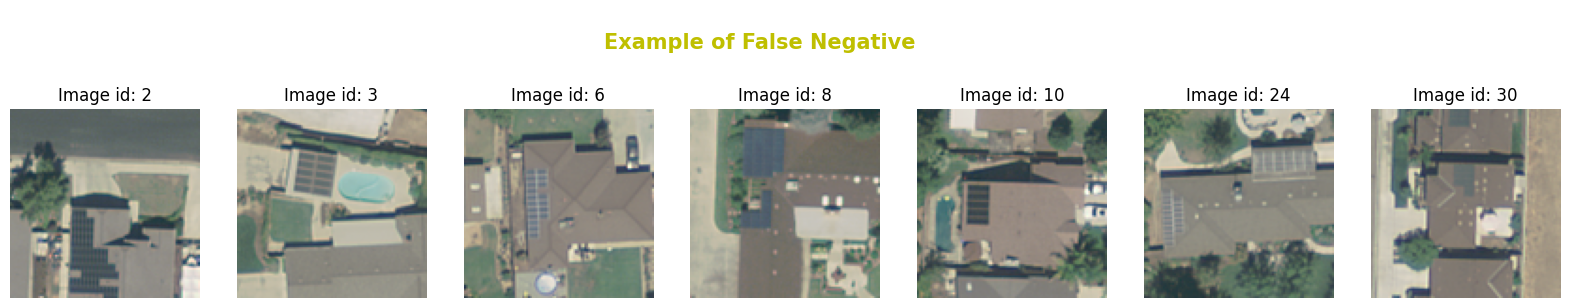

In [ ]:
# give an example for the number of the image = 7
num_images = 7
#use the funtion show_image above
show_images(tp, num_images, 'Examples of True Positive', 'g')
show_images(fp, num_images, 'Examples of False Positive', 'b')
show_images(tn, num_images, 'Example of True Negative', 'r')
show_images(fn, num_images, 'Example of False Negative', 'y')


### Evaluation the model and the results:


In [ ]:
# ROC - AUC
def plot_roc(y_true, y_pred_cnn):
    '''
    Plots ROC curves for the CNN models.
    '''
    plt.figure(figsize=(8, 8))

    # ROC of CNN
    fpr, tpr, _ = roc_curve(y_true, y_pred_cnn, pos_label=1)
    auc = roc_auc_score(y_true, y_pred_cnn)
    legend_string = 'CNN Model - AUC = {:0.3f}'.format(auc)
    plt.plot(fpr, tpr, color='red', label=legend_string)

    # ROC of chance
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Chance - AUC = 0.5')

    # plot aesthetics
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()
    plt.title('ROC Curve', fontsize=10)
    plt.show()


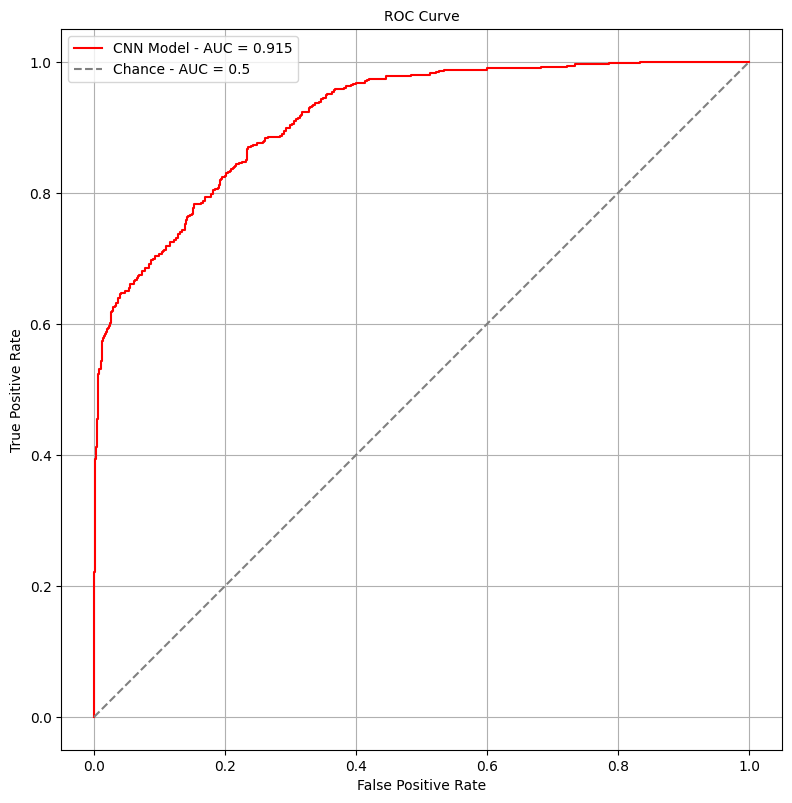

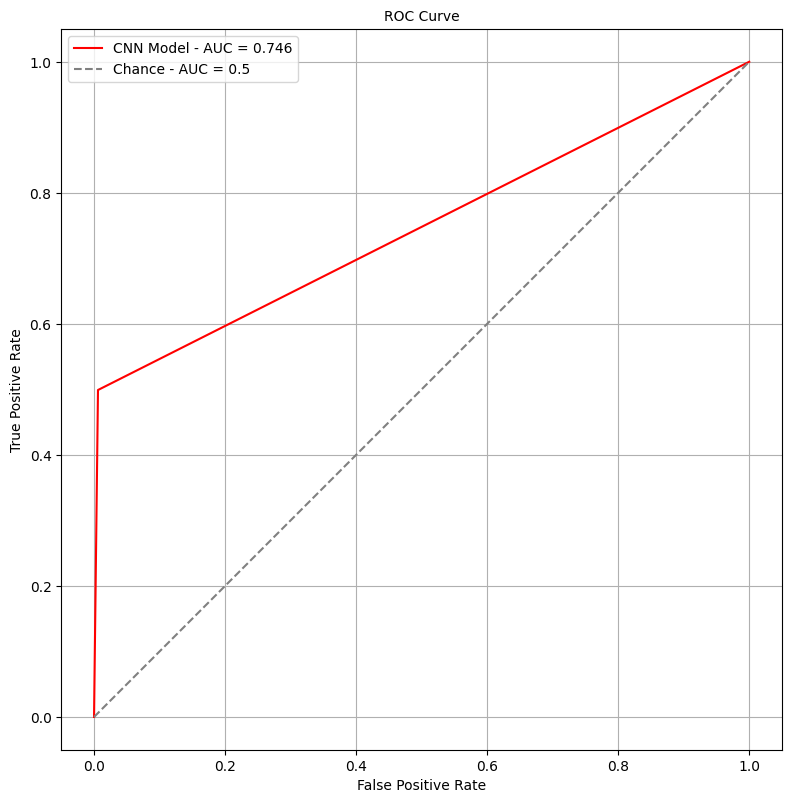

In [ ]:
# plot ROC
y_pred = [1 if pred >= 0.5 else 0 for pred in cnn_y_hat_prob]
plot_roc(y,  cnn_y_hat_prob)
plot_roc(y, y_pred)

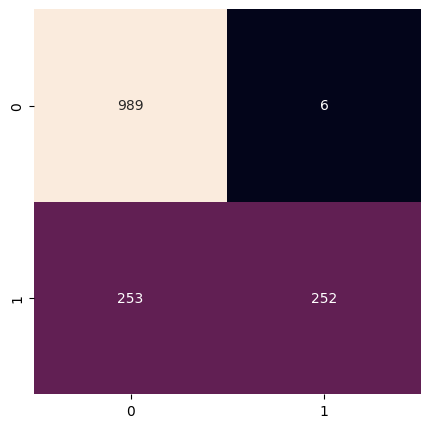

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(confusion_matrix(y, y_pred), annot = True, cbar = False, fmt='.0f')
plt.show()
#The top left square (dark blue) shows the number of true negatives (TN), where the model correctly predicted the negative class.
#The top right square (lighter shade) shows the number of false positives (FP), where the model incorrectly predicted the positive class.
#The bottom left square (also a lighter shade) shows the number of false negatives (FN), where the model incorrectly predicted the negative class.
#The bottom right square (dark purple) shows the number of true positives (TP), where the model correctly predicted the positive class.

In [ ]:
# Evaluate the performance
# evaluate classifier performance
from sklearn.metrics import classification_report
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.99      0.88       995
           1       0.98      0.50      0.66       505

    accuracy                           0.83      1500
   macro avg       0.89      0.75      0.77      1500
weighted avg       0.86      0.83      0.81      1500



Confusion Matrix:<br>
True Negatives (TN): The model correctly predicted 989 negative instances. <br>
False Positives (FP): It incorrectly predicted 6 instances as positive when they were negative. <br>
False Negatives (FN): The model incorrectly classified 253 positive instances as negative.<br>
True Positives (TP): It correctly identified 252 positive cases.
Classification Report:<br>
<br>
Precision:<br>
For the negative class (0), precision is 0.80, meaning 80% of predicted negatives were correct.<br>
For the positive class (1), precision is 0.98, indicating very few false positives.<br>
<br>
Recall:<br>
The model has high recall for the negative class (0) at 0.99, meaning almost all negative instances were correctly identified.<br>
The recall for the positive class (1) is lower at 0.50, indicating many positive cases were missed (high false negatives).<br>
F1-Score: The balance between precision and recall shows an overall F1-score of 0.88 for the negative class and 0.66 for the positive class, suggesting stronger performance in identifying negatives.<br>
Overall Accuracy: The model achieved an accuracy of 0.89, which means that 89% of all predictions were correct.<br>
<br>
Conclusion: The model performs well in predicting negative cases but struggles with identifying positive instances (low recall for class 1). While precision for both classes is strong, the higher false negatives (253) suggest potential areas for improvement, such as tuning the model or improving the dataset.